<a href="https://colab.research.google.com/github/ulgenklc/Sarcastic-Tweet-Detection/blob/main/sentiment_analysis_singh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Sentiment Analysis

**By Neuromatch Academy**

__Content creators:__  Juan Manuel Rodriguez, Salomey Osei, Gonzalo Uribarri

**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Step 1: Questions and goals

* Can we infer emotion from a tweet text?
* How words are distributed accross the dataset?
* Are words related to one kind of emotion?

---
# Step 2: Literature review

[Original Dataset Paper](https://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf)

[Papers with code](https://paperswithcode.com/dataset/imdb-movie-reviews)

---
# Step 3: Load and explore the dataset

##  Install dependencies


In [1]:
# @title Install dependencies
!pip install pandas --quiet
!pip install torchtext --quiet

In [2]:
# We import some libraries to load the dataset
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import torchtext
from torchtext.data import get_tokenizer

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

You can find the dataset we are going to use in [this website](http://help.sentiment140.com/for-students/).

In [3]:
#import requests, zipfile, io
#url = 'http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip'
#r = requests.get(url)
#z = zipfile.ZipFile(io.BytesIO(r.content))
#z.extractall()

In [4]:
# We load the dataset
path = '/Users/bengieru/Desktop/NMA-DL/iSarcasm/iSarcasm_dataset/'
header_list = ["text", "label", 'source']
df_train = pd.read_csv(path + 'cleandata/train.csv', encoding = "utf-8")
df_test = pd.read_csv(path + 'cleandata/test.csv', encoding = "utf-8")
df = pd.concat([df_train, df_test])
# Let's have a look at it
df.head()

,Unnamed: 0,text,label,source
0,0,sorry but sue from the mediweight advert looks...,False,3.0
1,1,@davesnyder since this is fantasy can it be an...,False,3.0
2,2,"Good times, fun times here in Grand old Britan...",True,3.0
3,3,I send light and love to all impacted by the #...,False,3.0
4,4,Another year closer to death,False,3.0


For this project we will use only the text and the polarity of the tweet. Notice that polarity is 0 for negative tweets and 4 for positive tweet.

In [5]:
# print(df.shape)
#len(df['user'].unique())

In [6]:
df.text.values[5]

'Looks like the leagues heading to the reds then'

In [7]:
(df.label.values>=1).astype(int)

array([0, 0, 1, ..., 0, 0, 0])

In [8]:
X = df.text.values
print(X.shape)
# Changes values from [0,4] to [0,1]
y = (df.label.values >= 1).astype(int)


# Split the data into train and test
x_train_text, x_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

(3556,)


The first thing we have to do before working on the models is to familiarize ourselves with the dataset. This is called Exploratory Data Analisys (EDA).

In [9]:
df1 = df.copy()

In [10]:
#remove URLs
import re
pattern=r'(?i)\b((?:[a-z][\w-]+:(?:/{1,3}|[a-z0-9%])|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))';
def rem_url(x):
    match = re.findall(pattern, x)
    for m in match:
        url = m[0]
        x = x.replace(url, '')
    return x

df1['url_removed'] = df1['text'].apply(lambda x:rem_url(x))
df1.head()

,Unnamed: 0,text,label,source,url_removed
0,0,sorry but sue from the mediweight advert looks...,False,3.0,sorry but sue from the mediweight advert looks...
1,1,@davesnyder since this is fantasy can it be an...,False,3.0,@davesnyder since this is fantasy can it be an...
2,2,"Good times, fun times here in Grand old Britan...",True,3.0,"Good times, fun times here in Grand old Britan..."
3,3,I send light and love to all impacted by the #...,False,3.0,I send light and love to all impacted by the #...
4,4,Another year closer to death,False,3.0,Another year closer to death


In [11]:
#remove twitter handles from text
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer(strip_handles=True)
df1['handle_removed'] = df1['url_removed'].apply(lambda x:tknzr.tokenize(x))
df1.head()

,Unnamed: 0,text,label,source,url_removed,handle_removed
0,0,sorry but sue from the mediweight advert looks...,False,3.0,sorry but sue from the mediweight advert looks...,"[sorry, but, sue, from, the, mediweight, adver..."
1,1,@davesnyder since this is fantasy can it be an...,False,3.0,@davesnyder since this is fantasy can it be an...,"[since, this, is, fantasy, can, it, be, any, i..."
2,2,"Good times, fun times here in Grand old Britan...",True,3.0,"Good times, fun times here in Grand old Britan...","[Good, times, ,, fun, times, here, in, Grand, ..."
3,3,I send light and love to all impacted by the #...,False,3.0,I send light and love to all impacted by the #...,"[I, send, light, and, love, to, all, impacted,..."
4,4,Another year closer to death,False,3.0,Another year closer to death,"[Another, year, closer, to, death]"


In [12]:
# detokenize the tweet again
from nltk.tokenize.treebank import TreebankWordDetokenizer
df1['detok'] = df1['handle_removed'].apply(lambda x:TreebankWordDetokenizer().detokenize(x))

df1.head()

,Unnamed: 0,text,label,source,url_removed,handle_removed,detok
0,0,sorry but sue from the mediweight advert looks...,False,3.0,sorry but sue from the mediweight advert looks...,"[sorry, but, sue, from, the, mediweight, adver...",sorry but sue from the mediweight advert looks...
1,1,@davesnyder since this is fantasy can it be an...,False,3.0,@davesnyder since this is fantasy can it be an...,"[since, this, is, fantasy, can, it, be, any, i...",since this is fantasy can it be any individual...
2,2,"Good times, fun times here in Grand old Britan...",True,3.0,"Good times, fun times here in Grand old Britan...","[Good, times, ,, fun, times, here, in, Grand, ...","Good times, fun times here in Grand old Britan..."
3,3,I send light and love to all impacted by the #...,False,3.0,I send light and love to all impacted by the #...,"[I, send, light, and, love, to, all, impacted,...",I send light and love to all impacted by the #...
4,4,Another year closer to death,False,3.0,Another year closer to death,"[Another, year, closer, to, death]",Another year closer to death


In [13]:
# remove punctuations
import string
string.punctuation
string.punctuation = string.punctuation + '’'## this is different than whats included in string.punctuation. apostrophe == shift + option + ']'
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
df1['punc_removed']= df1['detok'].apply(lambda x:remove_punctuation(x))
df1.head()

,Unnamed: 0,text,label,source,url_removed,handle_removed,detok,punc_removed
0,0,sorry but sue from the mediweight advert looks...,False,3.0,sorry but sue from the mediweight advert looks...,"[sorry, but, sue, from, the, mediweight, adver...",sorry but sue from the mediweight advert looks...,sorry but sue from the mediweight advert looks...
1,1,@davesnyder since this is fantasy can it be an...,False,3.0,@davesnyder since this is fantasy can it be an...,"[since, this, is, fantasy, can, it, be, any, i...",since this is fantasy can it be any individual...,since this is fantasy can it be any individual...
2,2,"Good times, fun times here in Grand old Britan...",True,3.0,"Good times, fun times here in Grand old Britan...","[Good, times, ,, fun, times, here, in, Grand, ...","Good times, fun times here in Grand old Britan...",Good times fun times here in Grand old Britannia
3,3,I send light and love to all impacted by the #...,False,3.0,I send light and love to all impacted by the #...,"[I, send, light, and, love, to, all, impacted,...",I send light and love to all impacted by the #...,I send light and love to all impacted by the v...
4,4,Another year closer to death,False,3.0,Another year closer to death,"[Another, year, closer, to, death]",Another year closer to death,Another year closer to death


In [14]:
# remove the upper case letters
df1['url_handle_punc_upper_removed'] = df1['punc_removed'].apply(lambda x: x.lower())
df1.head()

,Unnamed: 0,text,label,source,url_removed,handle_removed,detok,punc_removed,url_handle_punc_upper_removed
0,0,sorry but sue from the mediweight advert looks...,False,3.0,sorry but sue from the mediweight advert looks...,"[sorry, but, sue, from, the, mediweight, adver...",sorry but sue from the mediweight advert looks...,sorry but sue from the mediweight advert looks...,sorry but sue from the mediweight advert looks...
1,1,@davesnyder since this is fantasy can it be an...,False,3.0,@davesnyder since this is fantasy can it be an...,"[since, this, is, fantasy, can, it, be, any, i...",since this is fantasy can it be any individual...,since this is fantasy can it be any individual...,since this is fantasy can it be any individual...
2,2,"Good times, fun times here in Grand old Britan...",True,3.0,"Good times, fun times here in Grand old Britan...","[Good, times, ,, fun, times, here, in, Grand, ...","Good times, fun times here in Grand old Britan...",Good times fun times here in Grand old Britannia,good times fun times here in grand old britannia
3,3,I send light and love to all impacted by the #...,False,3.0,I send light and love to all impacted by the #...,"[I, send, light, and, love, to, all, impacted,...",I send light and love to all impacted by the #...,I send light and love to all impacted by the v...,i send light and love to all impacted by the v...
4,4,Another year closer to death,False,3.0,Another year closer to death,"[Another, year, closer, to, death]",Another year closer to death,Another year closer to death,another year closer to death


In [15]:
df1.columns

Index(['Unnamed: 0', 'text', 'label', 'source', 'url_removed',
       'handle_removed', 'detok', 'punc_removed',
       'url_handle_punc_upper_removed'],
      dtype='object')

In [16]:
# delete the unnecessary columns
del df1['Unnamed: 0']
del df1['url_removed']
del df1['handle_removed']
del df1['detok']
del df1['punc_removed']
df1.head()

,text,label,source,url_handle_punc_upper_removed
0,sorry but sue from the mediweight advert looks...,False,3.0,sorry but sue from the mediweight advert looks...
1,@davesnyder since this is fantasy can it be an...,False,3.0,since this is fantasy can it be any individual...
2,"Good times, fun times here in Grand old Britan...",True,3.0,good times fun times here in grand old britannia
3,I send light and love to all impacted by the #...,False,3.0,i send light and love to all impacted by the v...
4,Another year closer to death,False,3.0,another year closer to death


In [17]:
# tokenize
import re
def tokenization(text):
    tokens = re.split('W+',text)
    return tokens
#applying function to the column
# df1['msg_tokenied']= df1['msg_lower'].apply(lambda x: tokenization(x))
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer(strip_handles=True)
df1['msg_tokenied'] = df1['url_handle_punc_upper_removed'].apply(lambda x:tknzr.tokenize(x))
df1.head()

,text,label,source,url_handle_punc_upper_removed,msg_tokenied
0,sorry but sue from the mediweight advert looks...,False,3.0,sorry but sue from the mediweight advert looks...,"[sorry, but, sue, from, the, mediweight, adver..."
1,@davesnyder since this is fantasy can it be an...,False,3.0,since this is fantasy can it be any individual...,"[since, this, is, fantasy, can, it, be, any, i..."
2,"Good times, fun times here in Grand old Britan...",True,3.0,good times fun times here in grand old britannia,"[good, times, fun, times, here, in, grand, old..."
3,I send light and love to all impacted by the #...,False,3.0,i send light and love to all impacted by the v...,"[i, send, light, and, love, to, all, impacted,..."
4,Another year closer to death,False,3.0,another year closer to death,"[another, year, closer, to, death]"


In [18]:
# removing stop words
#importing nlp library
import nltk
nltk.download('stopwords')
#Stop words present in the library
stopwords = nltk.corpus.stopwords.words('english')
# stopwords[0:10]
#defining the function to remove stopwords from tokenized text
def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output

#applying the function
df1['no_stopwords']= df1['msg_tokenied'].apply(lambda x:remove_stopwords(x))
df1.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bengieru/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,label,source,url_handle_punc_upper_removed,msg_tokenied,no_stopwords
0,sorry but sue from the mediweight advert looks...,False,3.0,sorry but sue from the mediweight advert looks...,"[sorry, but, sue, from, the, mediweight, adver...","[sorry, sue, mediweight, advert, looks, incred..."
1,@davesnyder since this is fantasy can it be an...,False,3.0,since this is fantasy can it be any individual...,"[since, this, is, fantasy, can, it, be, any, i...","[since, fantasy, individual, time, alive, today]"
2,"Good times, fun times here in Grand old Britan...",True,3.0,good times fun times here in grand old britannia,"[good, times, fun, times, here, in, grand, old...","[good, times, fun, times, grand, old, britannia]"
3,I send light and love to all impacted by the #...,False,3.0,i send light and love to all impacted by the v...,"[i, send, light, and, love, to, all, impacted,...","[send, light, love, impacted, vegasshooting, k..."
4,Another year closer to death,False,3.0,another year closer to death,"[another, year, closer, to, death]","[another, year, closer, death]"


In [19]:
#importing the Stemming function from nltk library
from nltk.stem.porter import PorterStemmer
#defining the object for stemming
porter_stemmer = PorterStemmer()
#defining a function for stemming
def stemming(text):
    stem_text = [porter_stemmer.stem(word) for word in text]
    return stem_text

df1['msg_stemmed']=df1['no_stopwords'].apply(lambda x: stemming(x))
df1.head()

,text,label,source,url_handle_punc_upper_removed,msg_tokenied,no_stopwords,msg_stemmed
0,sorry but sue from the mediweight advert looks...,False,3.0,sorry but sue from the mediweight advert looks...,"[sorry, but, sue, from, the, mediweight, adver...","[sorry, sue, mediweight, advert, looks, incred...","[sorri, sue, mediweight, advert, look, incred,..."
1,@davesnyder since this is fantasy can it be an...,False,3.0,since this is fantasy can it be any individual...,"[since, this, is, fantasy, can, it, be, any, i...","[since, fantasy, individual, time, alive, today]","[sinc, fantasi, individu, time, aliv, today]"
2,"Good times, fun times here in Grand old Britan...",True,3.0,good times fun times here in grand old britannia,"[good, times, fun, times, here, in, grand, old...","[good, times, fun, times, grand, old, britannia]","[good, time, fun, time, grand, old, britannia]"
3,I send light and love to all impacted by the #...,False,3.0,i send light and love to all impacted by the v...,"[i, send, light, and, love, to, all, impacted,...","[send, light, love, impacted, vegasshooting, k...","[send, light, love, impact, vegasshoot, know, ..."
4,Another year closer to death,False,3.0,another year closer to death,"[another, year, closer, to, death]","[another, year, closer, death]","[anoth, year, closer, death]"


In [20]:
from nltk.stem import WordNetLemmatizer
#defining the object for Lemmatization
wordnet_lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
#defining the function for lemmatization
def lemmatizer(text):
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text

df1['msg_lemmatized']=df1['no_stopwords'].apply(lambda x:lemmatizer(x))
df1.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/bengieru/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,label,source,url_handle_punc_upper_removed,msg_tokenied,no_stopwords,msg_stemmed,msg_lemmatized
0,sorry but sue from the mediweight advert looks...,False,3.0,sorry but sue from the mediweight advert looks...,"[sorry, but, sue, from, the, mediweight, adver...","[sorry, sue, mediweight, advert, looks, incred...","[sorri, sue, mediweight, advert, look, incred,...","[sorry, sue, mediweight, advert, look, incredi..."
1,@davesnyder since this is fantasy can it be an...,False,3.0,since this is fantasy can it be any individual...,"[since, this, is, fantasy, can, it, be, any, i...","[since, fantasy, individual, time, alive, today]","[sinc, fantasi, individu, time, aliv, today]","[since, fantasy, individual, time, alive, today]"
2,"Good times, fun times here in Grand old Britan...",True,3.0,good times fun times here in grand old britannia,"[good, times, fun, times, here, in, grand, old...","[good, times, fun, times, grand, old, britannia]","[good, time, fun, time, grand, old, britannia]","[good, time, fun, time, grand, old, britannia]"
3,I send light and love to all impacted by the #...,False,3.0,i send light and love to all impacted by the v...,"[i, send, light, and, love, to, all, impacted,...","[send, light, love, impacted, vegasshooting, k...","[send, light, love, impact, vegasshoot, know, ...","[send, light, love, impacted, vegasshooting, k..."
4,Another year closer to death,False,3.0,another year closer to death,"[another, year, closer, to, death]","[another, year, closer, death]","[anoth, year, closer, death]","[another, year, closer, death]"


In [21]:
# detokenize the tweet again
df2 = df1.copy()

from nltk.tokenize.treebank import TreebankWordDetokenizer
df2['final'] = df2['msg_lemmatized'].apply(lambda x:TreebankWordDetokenizer().detokenize(x))
df2.head()

,text,label,source,url_handle_punc_upper_removed,msg_tokenied,no_stopwords,msg_stemmed,msg_lemmatized,final
0,sorry but sue from the mediweight advert looks...,False,3.0,sorry but sue from the mediweight advert looks...,"[sorry, but, sue, from, the, mediweight, adver...","[sorry, sue, mediweight, advert, looks, incred...","[sorri, sue, mediweight, advert, look, incred,...","[sorry, sue, mediweight, advert, look, incredi...",sorry sue mediweight advert look incredible go...
1,@davesnyder since this is fantasy can it be an...,False,3.0,since this is fantasy can it be any individual...,"[since, this, is, fantasy, can, it, be, any, i...","[since, fantasy, individual, time, alive, today]","[sinc, fantasi, individu, time, aliv, today]","[since, fantasy, individual, time, alive, today]",since fantasy individual time alive today
2,"Good times, fun times here in Grand old Britan...",True,3.0,good times fun times here in grand old britannia,"[good, times, fun, times, here, in, grand, old...","[good, times, fun, times, grand, old, britannia]","[good, time, fun, time, grand, old, britannia]","[good, time, fun, time, grand, old, britannia]",good time fun time grand old britannia
3,I send light and love to all impacted by the #...,False,3.0,i send light and love to all impacted by the v...,"[i, send, light, and, love, to, all, impacted,...","[send, light, love, impacted, vegasshooting, k...","[send, light, love, impact, vegasshoot, know, ...","[send, light, love, impacted, vegasshooting, k...",send light love impacted vegasshooting know lo...
4,Another year closer to death,False,3.0,another year closer to death,"[another, year, closer, to, death]","[another, year, closer, death]","[anoth, year, closer, death]","[another, year, closer, death]",another year closer death


In [22]:
df2.columns

Index(['text', 'label', 'source', 'url_handle_punc_upper_removed',
       'msg_tokenied', 'no_stopwords', 'msg_stemmed', 'msg_lemmatized',
       'final'],
      dtype='object')

In [23]:
del df2['msg_tokenied']
del df2['no_stopwords']
del df2['msg_stemmed']
del df2['msg_lemmatized']
df2.head()

,text,label,source,url_handle_punc_upper_removed,final
0,sorry but sue from the mediweight advert looks...,False,3.0,sorry but sue from the mediweight advert looks...,sorry sue mediweight advert look incredible go...
1,@davesnyder since this is fantasy can it be an...,False,3.0,since this is fantasy can it be any individual...,since fantasy individual time alive today
2,"Good times, fun times here in Grand old Britan...",True,3.0,good times fun times here in grand old britannia,good time fun time grand old britannia
3,I send light and love to all impacted by the #...,False,3.0,i send light and love to all impacted by the v...,send light love impacted vegasshooting know lo...
4,Another year closer to death,False,3.0,another year closer to death,another year closer death


In [24]:
# let's play with the lemmatized text to see how it's accuracy fairs
X = df2.final.values
print(X.shape)
# Changes values from [0,4] to [0,1]
y = (df2.label.values >= 1).astype(int)


# Split the data into train and test
x_train_text, x_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

(3556,)


In [25]:
for s, l in zip(x_train_text[:5], y_train[:5]):
    print('{}: {}'.format(l, s))

0: psa stop using fucking r word describing thing people
0: happened responsibility guess tax payer pick bill chose get insured
0: airdropping neighbor lot lately
0: today brake deer three separate occasion suppose better breaking four deer austintx
0: holy war nickname college football game u utah brigham young u n nboth school located utah one religious state union lds mormon game played tonight nationally televised


An interesting thing to analyze is the Word Distribution. In order to count the occurrences of each word, we should tokenize the sentences first.

In [26]:
tokenizer = get_tokenizer("basic_english")

# print('Before Tokenize: ', x_train_text[4])
# print('After Tokenize: ', tokenizer(x_train_text[4]))

In [27]:
x_train_token = [tokenizer(s) for s in tqdm(x_train_text)]
x_test_token = [tokenizer(s) for s in tqdm(x_test_text)]

  0%|          | 0/2844 [00:00<?, ?it/s]

  0%|          | 0/712 [00:00<?, ?it/s]

We can count the words occurences and see how many different words are present in our dataset.

In [28]:
words = Counter()
for s in x_train_token:
    for w in s:
        words[w] += 1

sorted_words = list(words.keys())
sorted_words.sort(key=lambda w: words[w], reverse=True)
print(f"Number of different Tokens in our Dataset: {len(sorted_words)}")
print(sorted_words[:20])

Number of different Tokens in our Dataset: 8880
['n', 'like', 'get', 'one', 'day', 'im', 'time', 'love', 'year', 'people', 'good', 'back', 'today', 'new', 'dont', 'go', 'really', 'need', 'make', 'thing']


Now we can plot their distribution.

In [29]:
count_occurences = sum(words.values())

accumulated = 0
counter = 0

while accumulated < count_occurences * 0.8:
    accumulated += words[sorted_words[counter]]
    counter += 1

print(f"The {counter * 100 / len(words)}% most common words "
      f"account for the {accumulated * 100 / count_occurences}% of the occurrences")

The 35.281531531531535% most common words account for the 80.00199448193332% of the occurrences


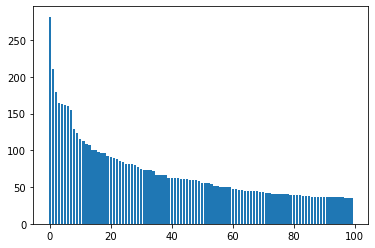

In [30]:
plt.bar(range(100), [words[w] for w in sorted_words[:100]])
plt.show()

In [31]:
for w in sorted_words[:10]:
    print(w, words[w])

n 282
like 211
get 179
one 164
day 163
im 162
time 160
love 155
year 129
people 124


In [32]:
final_data = df2.copy()
final_data.head()

,text,label,source,url_handle_punc_upper_removed,final
0,sorry but sue from the mediweight advert looks...,False,3.0,sorry but sue from the mediweight advert looks...,sorry sue mediweight advert look incredible go...
1,@davesnyder since this is fantasy can it be an...,False,3.0,since this is fantasy can it be any individual...,since fantasy individual time alive today
2,"Good times, fun times here in Grand old Britan...",True,3.0,good times fun times here in grand old britannia,good time fun time grand old britannia
3,I send light and love to all impacted by the #...,False,3.0,i send light and love to all impacted by the v...,send light love impacted vegasshooting know lo...
4,Another year closer to death,False,3.0,another year closer to death,another year closer death


In [33]:
del final_data['url_handle_punc_upper_removed']
final_data['text'] = final_data['final']
del final_data['final']
final_data.head()

,text,label,source
0,sorry sue mediweight advert look incredible go...,False,3.0
1,since fantasy individual time alive today,False,3.0
2,good time fun time grand old britannia,True,3.0
3,send light love impacted vegasshooting know lo...,False,3.0
4,another year closer death,False,3.0


In [34]:
final_data.to_csv(path + 'finaldata/train_test.csv')

It is very common to find this kind of distribution when analyzing corpus of text. This is referred to as the [zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law).

Usually the number of words in the dictionary will be very large. 

Here are some thing we can do to reduce that number:

* Remove puntuation.
* Remove stop-words.
* Steaming.
* Remove very uncommon words (the words that appears in fewer than N occations).
* Nothing: we can use a pretrain model that handles this kind of situations.


We used one of the simplest tokenizers availables. This tokenizer does not take into account many quirks of the language. Moreover, diferent languages have different quirks, so there is no "universal" tokenizers. There are many libraries that have "better" tokenizers:

* [Spacy](https://spacy.io/): it can be accessed using: `get_tokenizer("spacy")`. Spacy supports a wide range of languages.
* [Huggingface](https://huggingface.co/): it has many tokenizers for different laguages. [Doc](https://huggingface.co/transformers/main_classes/tokenizer.html)
* [NLTK](https://www.nltk.org/): it provides several tokenizers. One of them can be accessed using: `get_tokenizer("toktok")`


---
# Step 4: choose toolkit

Our goal is to train a model capable of estimating the sentiment of a tweet (positive or negative) by reading its content. To that end we will try 2 different approaches:

* A logistic regression using sklearn. **NOTE**: it can probaly work better than an SVM model.
* A simple Embedding + RNN.

## Logistic regression

We will represent our senteces using binary vectorization. This means that our data would be represented as a matrix of instances by word with a one if the word is in the instance, and zero otherwise. Sklean vectorizers can also do things such as stop-word removal and puntuation removal, you can read more about in [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

In [35]:
vectorizer = CountVectorizer(binary=True)
x_train_cv = vectorizer.fit_transform(x_train_text)
x_test_cv = vectorizer.transform(x_test_text)

In [36]:
print('Before Vectorize: ', x_train_text[3])

Before Vectorize:  today brake deer three separate occasion suppose better breaking four deer austintx


In [37]:
# Notice that the matriz is sparse
print('After Vectorize: ')
print(x_train_cv[3])

After Vectorize: 
  (0, 7724)	1
  (0, 1113)	1
  (0, 2057)	1
  (0, 7667)	1
  (0, 6757)	1
  (0, 5364)	1
  (0, 7392)	1
  (0, 916)	1
  (0, 1126)	1
  (0, 3009)	1
  (0, 693)	1


Now we can train our model. You can check the documentation of this logistic regressor [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logistic#sklearn.linear_model.LogisticRegression).

In [38]:
model = LogisticRegression(solver='saga')
model.fit(x_train_cv, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(solver='saga')

In [39]:
# prediction with lemmatized words
y_pred = model.predict(x_test_cv)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.98      0.90       591
           1       0.40      0.05      0.09       121

    accuracy                           0.83       712
   macro avg       0.62      0.52      0.50       712
weighted avg       0.76      0.83      0.77       712



In [40]:
# prediction with unprocessed text
y_pred = model.predict(x_test_cv)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.98      0.90       591
           1       0.40      0.05      0.09       121

    accuracy                           0.83       712
   macro avg       0.62      0.52      0.50       712
weighted avg       0.76      0.83      0.77       712



## Explainable AI
The best thing about logistic regresion is that it is simple, and we can get some explanations.

In [41]:
print(model.coef_.shape)
print(len(vectorizer.vocabulary_))

words_sk = list(vectorizer.vocabulary_.keys())
words_sk.sort(key=lambda w: model.coef_[0, vectorizer.vocabulary_[w]])

(1, 8574)
8574


In [42]:
for w in words_sk[:50]:
    print('{}: {}'.format(w, model.coef_[0, vectorizer.vocabulary_[w]]))

via: -1.1752597732802033
understand: -1.0299119696872854
win: -1.0182221637261157
2019: -1.0136698796156938
hey: -0.9535087776392258
later: -0.9450044096557335
full: -0.9266226725479921
help: -0.8639855073461573
food: -0.8622708746722914
family: -0.8599620742644077
month: -0.8410276095137329
birthday: -0.8289206066401767
say: -0.8261224237549929
friend: -0.8218561885056587
body: -0.81930587198056
video: -0.8068907838796939
20: -0.8034672130211626
thinking: -0.8002896480108793
book: -0.7969474774739418
honestly: -0.7866096804626721
club: -0.7637705748516359
cant: -0.7554259991498938
feel: -0.75332988590717
together: -0.7502454150406661
death: -0.7480538655412752
bloody: -0.7333739867739771
hand: -0.7233048544257363
finally: -0.713087231536759
see: -0.7094399310048186
listening: -0.7084077683393708
stop: -0.7030980658877556
quality: -0.7009150070195914
show: -0.691658166974679
used: -0.6852787761288001
walking: -0.6835207202700383
anymore: -0.6761026642321657
whole: -0.6689767035207639
d

In [43]:
for w in reversed(words_sk[-50:]):
    print('{}: {}'.format(w, model.coef_[0, vectorizer.vocabulary_[w]]))

guess: 1.424743209542342
might: 1.36446616238849
sarcasm: 1.2930004579495065
thanks: 1.275814989978765
minute: 1.225813060589463
job: 1.1291166963093122
box: 1.1278356620513723
brexit: 1.102292003369904
speech: 1.093691230429544
30: 0.9955425878957399
anything: 0.9582292948456163
delivery: 0.9526965949007302
dear: 0.9526599721183322
sure: 0.9177999194419594
alcohol: 0.9171957819800233
brian: 0.9130138331386375
didnt: 0.9030123805649728
skip: 0.9026988148820189
brand: 0.886931052615735
gotta: 0.8849081597402486
joke: 0.8779836857513911
blocked: 0.8774880326750588
fuss: 0.8760237069409876
insomnia: 0.8681191763362874
million: 0.8642895111809893
eat: 0.8624302648933724
falling: 0.8514201710232847
as: 0.8436281192395328
official: 0.8422684557261607
finger: 0.8352230678486665
prof: 0.8351269369445319
helpful: 0.8296163257543824
magic: 0.8254136522050921
oh: 0.823761871312721
killed: 0.8181270275799074
tom: 0.8155222980847641
trump: 0.8150810728785728
love: 0.8092761984824047
trailer: 0.8091

What does this mean?

Remember the `model.coef_` is the $W$ in:

$$h(x)=\sigma(WX + b)$$

where the label 1 is a positive tweet and the label 0 is a negative tweet.

## Recurrent Neural Network with Pytorch

In the previous section we use a Bag-Of-Words approach to represent each of the tweets. That meas that we only consider how many times each of the words appear in each of the tweets, we didnt take into account the order of the words. But we know that the word order is very important and carries relevant information.

In this section we will solve the same task, but this time we will implement a Recurrent Neural Network (RNN) instead of using a simple Logistic Regression.Unlike feedforward neural networks, RNNs have cyclic connections making them powerful for modeling sequences.

Let's start by importing the relevant libraries.


In [44]:
def set_device():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        print("WARNING: For this notebook to perform best, if possible, in the menu under `Runtime` -> `Change runtime type.`  select `GPU` ")
    else:
        print("GPU is enabled in this notebook.")

    return device

In [45]:
# Set the device (check if gpu is available)
device = set_device()

First we will create a Dictionary (`word_to_idx`). This dictionary will map each Token (usually words) to an index (an integer number). We want to limit our dictionary to a certain number of tokens (`num_words_dict`), so we will include in our ditionary those with more occurrences.

In [46]:
# From previous section, we have a list with the most used tokens
sorted_words[:10]

['n', 'like', 'get', 'one', 'day', 'im', 'time', 'love', 'year', 'people']

In [47]:
len(sorted_words)

8880

Let's select only the most used.

In [48]:
num_words_dict = 5000
# We reserve two numbers for special tokens.
most_used_words = sorted_words[:num_words_dict-2]

We will add two extra Tokens to the dictionary, one for words outside the dictionary (`'UNK'`) and one for padding the sequences (`'PAD'`).

In [49]:
# dictionary to go from words to idx 
word_to_idx = {}
# dictionary to go from idx to words (just in case) 
idx_to_word = {}


# We include the special tokens first
PAD_token = 0   
UNK_token = 1

word_to_idx['PAD'] = PAD_token
word_to_idx['UNK'] = UNK_token

idx_to_word[PAD_token] = 'PAD'
idx_to_word[UNK_token] = 'UNK'

# We popullate our dictionaries with the most used words
for num,word in enumerate(most_used_words):
    word_to_idx[word] = num + 2
    idx_to_word[num+2] = word

Our goal now is to transform each tweet from a sequence of tokens to a sequence of indexes. These sequences of indexes will be the input to our pytorch model.

In [50]:
# A function to convert list of tokens to list of indexes
def tokens_to_idx(sentences_tokens,word_to_idx):
    sentences_idx = []
    for sent in sentences_tokens:
        sent_idx = []
        for word in sent:
            if word in word_to_idx:
                sent_idx.append(word_to_idx[word])
            else:
                sent_idx.append(word_to_idx['UNK'])
        sentences_idx.append(sent_idx)
    return sentences_idx

In [51]:
x_train_idx = tokens_to_idx(x_train_token,word_to_idx)
x_test_idx = tokens_to_idx(x_test_token,word_to_idx)

In [52]:
len(x_train_idx), len(x_test_idx)

(2844, 712)

In [53]:
some_number = 1
print('Before converting: ', x_train_token[some_number])
print('After converting: ', x_train_idx[some_number])

Before converting:  ['happened', 'responsibility', 'guess', 'tax', 'payer', 'pick', 'bill', 'chose', 'get', 'insured']
After converting:  [362, 1222, 255, 721, 2163, 626, 1223, 1559, 4, 3405]


We need all the sequences to have the same length. To select an adequate sequence length, let's explore some statistics about the length of the tweets:

In [54]:
tweet_lens = np.asarray([len(sentence) for sentence in x_train_idx])
print('Max tweet word length: ',tweet_lens.max())
print('Mean tweet word length: ',np.median(tweet_lens))
print('99% percent under: ',np.quantile(tweet_lens,0.99))

Max tweet word length:  50
Mean tweet word length:  9.0
99% percent under:  29.0


We cut the sequences which are larger than our chosen maximum length (`max_lenght`) and fill with zeros the ones that are shorter.

In [55]:
 # We choose the max length
max_length = 30

# A function to make all the sequence have the same lenght
# Note that the output is a Numpy matrix
def padding(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, tweet in enumerate(sentences):
        len_tweet = len(tweet) 
        if len_tweet != 0:
            if len_tweet <= seq_len:
        # If its shorter, we fill with zeros (the padding Token index)
                features[ii, -len(tweet):] = np.array(tweet)[:seq_len]
            if len_tweet > seq_len:
        # If its larger, we take the last 'seq_len' indexes
                features[ii, :] = np.array(tweet)[-seq_len:]
    return features

In [56]:
# We convert our list of tokens into a numpy matrix
# where all instances have the same lenght
x_train_pad = padding(x_train_idx,max_length)
x_test_pad = padding(x_test_idx,max_length)

# We convert our target list a numpy matrix
y_train_np = np.asarray(y_train)
y_test_np = np.asarray(y_test)

In [57]:
some_number = 2
print('Before padding: ', x_train_idx[some_number])
print('After padding: ', x_train_pad[some_number])

Before padding:  [3406, 1560, 164, 722]
After padding:  [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0 3406 1560
  164  722]


Now, let's convert the data to pytorch format.


In [58]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train_np))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test_np))

# Batch size (this is an important hyperparameter)
batch_size = 100

# dataloaders
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,drop_last = True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size,drop_last = True)

In [59]:
x_train_pad.shape, x_test_pad.shape, y_train_np.shape, y_test_np.shape

((2844, 30), (712, 30), (2844,), (712,))

Each batch of data in our traning proccess will have the folllowing format:

In [60]:
# Obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([100, 30])
Sample input: 
 tensor([[   0,    0,    0,  ...,  689,  689,  689],
        [   0,    1,  832,  ...,    1,    1,    1],
        [   0,    0,    0,  ..., 4467, 2596, 4468],
        ...,
        [   0,    0,    0,  ...,  749, 1661, 4368],
        [   0,    0,    0,  ...,  120,  120, 2062],
        [   0,    0,    0,  ...,  990,    1,    1]])
Sample input: 
 tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0])


Now, we will define the `SentimentRNN` class. Most of the model's class will be familiar to you, but there are two important layers we would like you to pay attention to:

*   Embedding Layer
> This layer is like a linear layer, but it makes it posible to use a sequence of inedexes as inputs (instead of a sequence of one-hot-encoded vectors). During training, the Embedding layer learns a linear transformation from the space of words (a vector space of dimension `num_words_dict`) into the a new, smaller, vector space of dimension `embedding_dim`. We suggest you to read this [thread](https://discuss.pytorch.org/t/how-does-nn-embedding-work/88518/3) and the [pytorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) if you want to learn more about this particular kind of layers.


*   LSTM layer
> This is one of the most used class of Recurrent Neural Networks. In Pytorch we can add several stacked layers in just one line of code. In our case, the number of layers added are decided with the parameter `no_layers`. If you want to learn more about LSTMs we strongly recommend you this [Colahs thread](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) about them.







In [61]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.1):
        super(SentimentRNN,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.no_layers = no_layers
        self.vocab_size = vocab_size
        self.drop_prob = drop_prob

    # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

    # LSTM Layers
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                            num_layers=no_layers, batch_first=True, 
                            dropout=self.drop_prob)

    # Dropout layer
        self.dropout = nn.Dropout(drop_prob)

    # Linear and Sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
      
    def forward(self,x,hidden):
        batch_size = x.size(0)

    # Embedding out
        embeds = self.embedding(x)
    #Shape: [batch_size x max_length x embedding_dim]

    # LSTM out
        lstm_out, hidden = self.lstm(embeds, hidden)
    # Shape: [batch_size x max_length x hidden_dim]

    # Select the activation of the last Hidden Layer
        lstm_out = lstm_out[:,-1,:].contiguous()
    # Shape: [batch_size x hidden_dim]

    ## You can instead average the activations across all the times
    # lstm_out = torch.mean(lstm_out, 1).contiguous()

    # Dropout and Fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

    # Sigmoid function
        sig_out = self.sig(out)

    # return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
    # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
    # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

We choose the parameters of the model.

In [62]:
# Parameters of our network

# Size of our vocabulary
vocab_size = num_words_dict

# Embedding dimension
embedding_dim = 32

# Number of stacked LSTM layers
no_layers = 2

# Dimension of the hidden layer in LSTMs
hidden_dim = 64

# Dropout parameter for regularization
output_dim = 1

# Dropout parameter for regularization
drop_prob = 0.25

In [63]:
# Let's define our model
model = SentimentRNN(no_layers, vocab_size, hidden_dim,
                     embedding_dim, drop_prob=drop_prob)
# Moving to gpu
model.to(device)
print(model)

SentimentRNN(
  (embedding): Embedding(5000, 32)
  (lstm): LSTM(32, 64, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [64]:
# How many trainable parameters does our model have?
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Total Number of parameters: ',params)

Total Number of parameters:  218433


In [76]:
np.linspace(0.0005,0.0015,11)

array([0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001 , 0.0011, 0.0012,
       0.0013, 0.0014, 0.0015])

We choose the losses and the optimizer for the training procces.

In [77]:
# loss and optimization functions
lrs = np.linspace(0.0005,0.0015,11)#define a range of learning rates

# Binary crossentropy is a good loss function for a binary classification problem
criterion = nn.BCELoss()

# We choose an Adam optimizer
optimizers = []
for i,lr in enumerate(lrs):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizers.append(optimizer)
# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

We are ready to train our model.

In [78]:
# Number of training Epochs
epochs = 5

# Maximum absolute value accepted for the gradeint
clip = 5

# Initial Loss value (assumed big)
valid_loss_min = np.Inf

# Lists to follow the evolution of the loss and accuracy
epoch_tr_loss,epoch_vl_loss = [[] for i in range(len(lrs))],[[] for i in range(len(lrs))]
epoch_tr_acc,epoch_vl_acc = [[] for i in range(len(lrs))],[[] for i in range(len(lrs))]

# Train for a number of Epochs
for i, lr in enumerate(lrs):
    for epoch in range(epochs):
        train_losses = []
        train_acc = 0.0
        model.train()
  
        for inputs, labels in train_loader:

    # Initialize hidden state 
            h = model.init_hidden(batch_size)
    # Creating new variables for the hidden state
            h = tuple([each.data.to(device) for each in h])

    # Move batch inputs and labels to gpu
            inputs, labels = inputs.to(device), labels.to(device)   

    # Set gradient to zero
            model.zero_grad()

    # Compute model output
            output,h = model(inputs,h)

    # Calculate the loss and perform backprop
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            train_losses.append(loss.item())

    # calculating accuracy
            accuracy = acc(output,labels)
            train_acc += accuracy

    #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizers[i].step()

  
  # Evaluate on the validation set for this epoch 
        val_losses = []
        val_acc = 0.0
        model.eval()
        for inputs, labels in valid_loader:

    # Initialize hidden state 
            val_h = model.init_hidden(batch_size)
            val_h = tuple([each.data.to(device) for each in val_h])

    # Move batch inputs and labels to gpu
            inputs, labels = inputs.to(device), labels.to(device)

    # Compute model output
            output, val_h = model(inputs, val_h)

    # Compute Loss
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())

            accuracy = acc(output,labels)
            val_acc += accuracy
          
        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)
        epoch_train_acc = train_acc/len(train_loader.dataset)
        epoch_val_acc = val_acc/len(valid_loader.dataset)
        epoch_tr_loss[i].append(epoch_train_loss)
        epoch_vl_loss[i].append(epoch_val_loss)
        epoch_tr_acc[i].append(epoch_train_acc)
        epoch_vl_acc[i].append(epoch_val_acc)
        print(f'Epoch {epoch+1}') 
        print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
        print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
        if epoch_val_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
    # torch.save(model.state_dict(), '../working/state_dict.pt')
            valid_loss_min = epoch_val_loss
        print(25*'==')

Epoch 1
train_loss : 0.6005141107099397 val_loss : 0.4744860700198582
train_accuracy : 80.94233473980309 val_accuracy : 81.60112359550563
Validation loss decreased (inf --> 0.474486).  Saving model ...
Epoch 2
train_loss : 0.4693986475467682 val_loss : 0.46185442379542757
train_accuracy : 81.57524613220815 val_accuracy : 81.46067415730337
Validation loss decreased (0.474486 --> 0.461854).  Saving model ...
Epoch 3
train_loss : 0.4597174557191985 val_loss : 0.45728922741753714
train_accuracy : 81.61040787623067 val_accuracy : 81.60112359550563
Validation loss decreased (0.461854 --> 0.457289).  Saving model ...
Epoch 4
train_loss : 0.45545046989406857 val_loss : 0.4608643778732845
train_accuracy : 81.82137834036568 val_accuracy : 81.32022471910112
Epoch 5
train_loss : 0.45515024981328417 val_loss : 0.45569700428417753
train_accuracy : 81.75105485232066 val_accuracy : 81.60112359550563
Validation loss decreased (0.457289 --> 0.455697).  Saving model ...
Epoch 1
train_loss : 0.45677024977

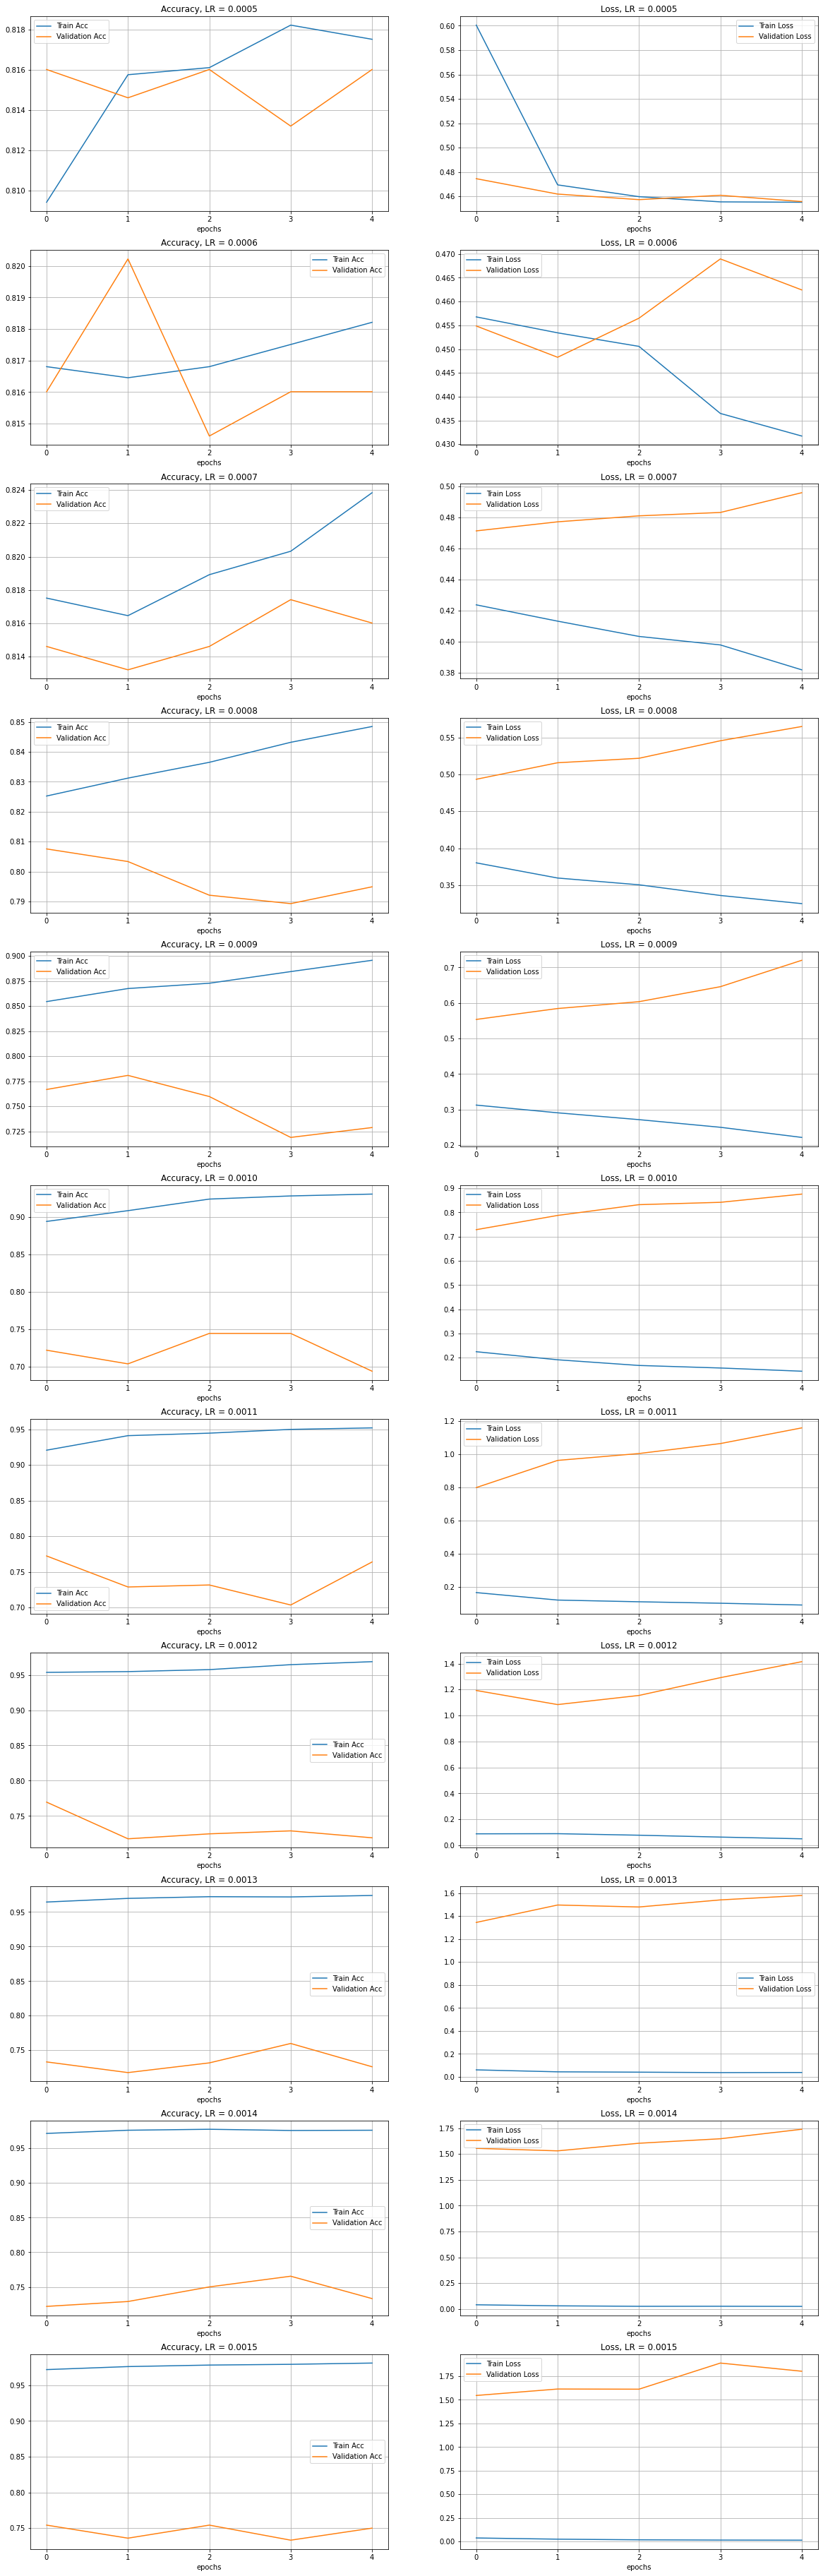

In [80]:
fig, ax = plt.subplots(11,2, figsize = (20,66))
for i, lr in enumerate(lrs):
    ax[i][0].plot(epoch_tr_acc[i], label='Train Acc')
    ax[i][0].plot(epoch_vl_acc[i], label='Validation Acc')
    ax[i][0].set_xlabel('epochs')
    ax[i][0].set_xticks([0,1,2,3,4])
    ax[i][0].set_title('Accuracy, LR = %.4f'%lr)
    ax[i][0].legend()
    ax[i][0].grid()
    
    ax[i][1].plot(epoch_tr_loss[i], label='Train Loss')
    ax[i][1].plot(epoch_vl_loss[i], label='Validation Loss')
    ax[i][1].set_xlabel('epochs')
    ax[i][1].set_xticks([0,1,2,3,4])
    ax[i][1].set_title('Loss, LR = %.4f'%lr)
    ax[i][1].legend()
    ax[i][1].grid()

In [87]:
np.savetxt('/Users/bengieru/Desktop/NMA-DL/iSarcasm/Results/learning_rate_tr_acc.txt', epoch_tr_acc)
np.savetxt('/Users/bengieru/Desktop/NMA-DL/iSarcasm/Results/learning_rate_tr_loss.txt', epoch_tr_loss)
np.savetxt('/Users/bengieru/Desktop/NMA-DL/iSarcasm/Results/learning_rate_vl_loss.txt', epoch_vl_loss)
np.savetxt('/Users/bengieru/Desktop/NMA-DL/iSarcasm/Results/learning_rate_vl_acc.txt', epoch_vl_acc)

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

---
# What's Next?

You can use this project template as a starting point to think about your own project. There are a lot of ways to continue, here we share with you some ideas you migth find useful:

*   **Work on the Preproccesing.** We used a very rudimentary way to tokenize tweets. But there are better ways to preprocess the data. Can you think of a suitable way to preprocess the data for this particular task? How does the performance of the model change when the data is processed correctly?
*   **Work on the Model.** The RNN model proposed in this notebook is not optimized at all. You can work on finding a better architecture or better hyperparamenters. May be using bidirectonal LSTMs or increasing the number of stacked layers can improve the performance, feel free to try different approaches.
*   **Work on the Embedding.** Our model learnt an embedding during the training on this Twitter corpus for a particular task. You can explore the representation of different words in this learned embedding. Also, you can try using different word embeddings. You can train them on this corpus or you can use an embedding trained on another corpus of data. How does the change of the embedding affect the model performance?
*   **Try sentiment analysis on another dataset.** There are lots of available dataset to work with, we can help you find one that is interesting to you. Do you belive that a sentiment analysis model trained on some corpus (Twitter dataset) will perform well on another type of data (for example, youtube comments)?

